In [1]:
#### 載入套件
import torch
import torch.nn as nn
import torch.optim

#蒐集器，可以讓統計字詞更簡單
from collections import Counter 


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
%matplotlib inline

## 一、自行生成訓練用字符串

首先，我們生成大量的形如$0^n1^n$這樣的字符串。為了讓訓練能夠有更好的效果，我們故意生成了較多n比較小的字符串

所有字符串都是如下的形式：30001112,300112,3012,...

3為起始值的標記符號；2為終止值的標記符號。

In [2]:
train_set = []
valid_set = []

# 生成的樣本數量
samples = 2000

# 訓練樣本中n的最大值
sz = 10
# 定義不同n的權重，我們按照10:6:4:3:1:1...來配置字符串生成中的n=1,2,3,4,5,...
probability = 1.0 * np.array([10, 6, 4, 3, 1, 1, 1, 1, 1, 1])
#保證n的最大值為sz
probability = probability[ : sz]
# 歸一化，將權重變成概率
probability = probability / sum(probability)

# 開始生成samples這麽多個樣本
for m in range(samples):
    # 對於每一個生成的字符串，隨機選擇一個n，n被選擇的權重被記錄在probability中
    n = np.random.choice(range(1, sz + 1), p = probability) # 從p(list)的機率中選1-10當作序列長度
    # 生成這個字符串，用list的形式完成記錄
    inputs = [0] * n + [1] * n
    # 在最前面插入3表示起始字符，2插入尾端表示終止字符
    inputs.insert(0, 3)
    inputs.append(2)
    train_set.append(inputs) #將生成的字符串加入到train_set訓練集中
    
# 再生成samples/10的校驗樣本
for m in range(samples // 10):
    n = np.random.choice(range(1, sz + 1), p = probability)
    inputs = [0] * n + [1] * n
    inputs.insert(0, 3)
    inputs.append(2)
    valid_set.append(inputs)

# 再生成若幹n超大的校驗樣本
for m in range(2):
    n = sz + m
    inputs = [0] * n + [1] * n
    inputs.insert(0, 3)
    inputs.append(2)
    valid_set.append(inputs)
np.random.shuffle(valid_set) #打散val

#train : 2000筆
#val : 202筆

## 二、用RNN來進行學習

首先，我們先讓RNN來對這些字符串進行學習，然後再去實驗LSTM的效果

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        
        super(SimpleRNN, self).__init__()
# 變數
        self.hidden_size = hidden_size
        self.num_layers = num_layers
# 基本層         
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        
#embedding層
        x = self.embedding(input)            # x的尺寸：batch_size, len_seq, hidden_size
# 從輸入到隱含層的計算
        output, hidden = self.rnn(x, hidden) # output的尺寸：batch_size, len_seq, hidden_size
                                             # hidden的尺寸: layer_size, batch_size, hidden_size
        output = output[:,-1,:]              # output的尺寸：batch_size         , hidden_size
        output = self.fc(output) 
# softmax函數
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        
# 注意尺寸是： layers, batch_size, hidden_size
        return torch.zeros(self.num_layers, 1, self.hidden_size)


### 2、訓練神經網絡

我們進行了三重循環。

Epoch作為第一循環

    再每個train_set中的字符串做第二循環
    
         最後對每一個字符串中的每一個字符做循環

In [4]:
train_set

[[3, 0, 1, 2],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2],
 [3, 0, 0, 1, 1, 2],
 [3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
 [3, 0, 0, 1, 1, 2],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
 [3, 0, 0, 1, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 0, 0, 0, 1, 1, 1, 1, 2],
 [3, 0, 0, 1, 1, 2],
 [3, 0, 0, 0, 1, 1, 1, 2],
 [3, 0, 0, 0, 1, 1, 1, 2],
 [3, 0, 0, 0, 1, 1, 1, 2],
 [3, 0, 0, 0, 1, 1, 1, 2],
 [3, 0, 0, 0, 0, 1, 1, 1, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 0, 0, 0, 1, 1, 1, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2],
 [3, 0, 0, 0, 1, 1, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 0, 0, 1, 1, 1, 2],
 [3, 0, 1, 2],
 [3, 0, 0, 1, 1, 2],
 [3, 0, 0, 1, 1, 2],
 [3, 0, 0, 0, 1, 1, 1, 2],
 [3, 0, 0, 0, 0, 1, 1, 1, 1, 2],
 [3, 0, 0,

In [5]:
# 生成一個最簡化的RNN，輸入size為4，可能值為0,1,2,3，輸出size為3，可能值為0,1,2
rnn = SimpleRNN(input_size = 4, hidden_size = 2, output_size = 3)
criterion = torch.nn.NLLLoss() #交叉熵損失函數
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.001) #Adam優化算法



num_epoch = 50
results = []

#重覆進行50次試驗
for epoch in range(num_epoch):
    rnn.train()
    train_loss = 0
    
    # 對train_set中的數據進行隨機洗牌，以保證每個epoch得到的訓練順序都不一樣。
    np.random.shuffle(train_set)
    
    # 對train_set中的數據進行循環
    for i, seq in enumerate(train_set):
        loss = 0
        hidden = rnn.initHidden()  #初始化隱含層神經元
        
        # 對每一個序列的所有字符進行循環
        for t in range(len(seq) - 1):
            #當前字符作為輸入，下一個字符作為標簽
            x = torch.LongTensor([seq[t]]).unsqueeze(0)
            # x尺寸：batch_size = 1, len_seq = 1, input_size = 1
            # unsqueeze(0)在只指定位置增加一維度，目的是為了增加batch。 
            # 因為 batch_first = True 所以順序被對調了。
            
            y = torch.LongTensor([seq[t + 1]])
            # y尺寸：batch_size = 1, input_size = 1
            
            output, hidden = rnn(x ,hidden) #RNN輸出
            # output尺寸：batch_size = x的batch_size, output_size = 3
                         # 因為選取最後一步的輸出結果，所以len_seq不見了。
            # hidden尺寸：layer_size =1, batch_size=1, hidden_size
            
            loss += criterion(output, y) #計算損失函數
            
        loss = 1.0 * loss / len(seq) #計算每字符的損失數值
        optimizer.zero_grad() # 梯度清空
        loss.backward() #反向傳播，設置retain_variables
        optimizer.step() #一步梯度下降
        train_loss += loss #累積損失函數值
        
        # 把結果打印出來
        if i > 0 and i % 500 == 0:
            print('第{}輪, 第{}個，訓練Loss:{:.2f}'.format(epoch,
                                                    i,
                                                    train_loss.data.numpy() / i
                                                   ))
            
    # 在校驗集上測試

    valid_loss = 0
    errors = 0
    show_out = ''
    rnn.eval()
    # 對每一個valid_set中的字符串做循環
    with torch.no_grad():
        
        for i, seq in enumerate(valid_set):

            loss = 0
            outstring = ''
            targets = ''
            diff = 0
            hidden = rnn.initHidden() #初始化隱含層神經元

            # 對每一個字符做循環
            for t in range(len(seq) - 1):

                x = torch.tensor([seq[t]], dtype = torch.long).unsqueeze(0)
                # x尺寸：batch_size = 1, time_steps = 1, data_dimension = 1

                y = torch.tensor([seq[t + 1]], dtype = torch.long)
                # y尺寸：batch_size = 1, data_dimension = 1

                output, hidden = rnn(x, hidden)
                # output尺寸：batch_size, output_size = 3
                # hidden尺寸：layer_size =1, batch_size=1, hidden_size

                mm = torch.max(output, 1)[1][0] #以概率最大的元素作為輸出 
                                                #torch.max 給出([機率,輸出])，所以取的是位置，最後的[0]是取值

                outstring += str(mm.data.numpy()) #合成預測的字符串
                targets += str(y.data.numpy()[0]) #合成目標字符串  
                                                  #[0]取值

                loss += criterion(output, y) #計算損失函數
                diff += 1 - mm.eq(y).data.numpy()[0] #計算模型輸出字符串與目標字符串之間差異的字符數量
                                                     # return T or F
            loss = 1.0 * loss / len(seq)
            valid_loss += loss #累積損失函數值
            errors += diff #計算累積錯誤數
            if np.random.rand() < 0.1:  # np.random.rand() 生成[0, 1)之間的小數
                #以0.1概率記錄一個輸出字符串
                show_out = outstring + '\n' + targets

    # 打印結果
    print('第{}輪, 訓練Loss:{:.2f}, 校驗Loss:{:.2f}, 錯誤率:{:.2f}'.format(epoch, 
                                                               train_loss.data.numpy() / len(train_set),
                                                               valid_loss.data.numpy()/ len(valid_set),
                                                               1.0 * errors / len(valid_set)
                                                              ))
    print(show_out)
    results.append([train_loss.data.numpy() / len(train_set), 
                    valid_loss.data.numpy() / len(train_set),
                   1.0 * errors / len(valid_set)
                   ])

第0輪, 第500個，訓練Loss:0.78
第0輪, 第1000個，訓練Loss:0.69
第0輪, 第1500個，訓練Loss:0.63
第0輪, 訓練Loss:0.59, 校驗Loss:0.45, 錯誤率:2.74
012
012
第1輪, 第500個，訓練Loss:0.44
第1輪, 第1000個，訓練Loss:0.42
第1輪, 第1500個，訓練Loss:0.42
第1輪, 訓練Loss:0.41, 校驗Loss:0.38, 錯誤率:2.59
012
012
第2輪, 第500個，訓練Loss:0.37
第2輪, 第1000個，訓練Loss:0.37
第2輪, 第1500個，訓練Loss:0.37
第2輪, 訓練Loss:0.36, 校驗Loss:0.35, 錯誤率:1.48
00012
00112
第3輪, 第500個，訓練Loss:0.35
第3輪, 第1000個，訓練Loss:0.35
第3輪, 第1500個，訓練Loss:0.34
第3輪, 訓練Loss:0.34, 校驗Loss:0.33, 錯誤率:1.33
00012
00112
第4輪, 第500個，訓練Loss:0.33
第4輪, 第1000個，訓練Loss:0.33
第4輪, 第1500個，訓練Loss:0.33
第4輪, 訓練Loss:0.32, 校驗Loss:0.31, 錯誤率:1.79
01100011212
00000111112
第5輪, 第500個，訓練Loss:0.31
第5輪, 第1000個，訓練Loss:0.31
第5輪, 第1500個，訓練Loss:0.31
第5輪, 訓練Loss:0.31, 校驗Loss:0.30, 錯誤率:1.48
002
012
第6輪, 第500個，訓練Loss:0.30
第6輪, 第1000個，訓練Loss:0.30
第6輪, 第1500個，訓練Loss:0.29
第6輪, 訓練Loss:0.29, 校驗Loss:0.28, 錯誤率:1.00
00012
00112
第7輪, 第500個，訓練Loss:0.29
第7輪, 第1000個，訓練Loss:0.29
第7輪, 第1500個，訓練Loss:0.28
第7輪, 訓練Loss:0.28, 校驗Loss:0.27, 錯誤率:1.18
0010000111112
0000001111112


In [6]:
# 保存、提取模型（為展示用）
torch.save(rnn,'rnn.mdl')
rnn = torch.load('rnn.mdl')

### 3. 測試結果好壞

我們讓n從0循環到20，考察模型預測的結果如何

只有當模型能夠預測出最後一個1後面應該跟2（字串結束字符）才算預測正確，也就意味著模型記憶住了n這個數字。

In [7]:
for n in range(50):
    
    inputs = [0] * n + [1] * n
    inputs.insert(0, 3)
    inputs.append(2)
    outstring = ''
    targets = ''
    diff = 0
    hiddens = []
    hidden = rnn.initHidden()
    for t in range(len(inputs) - 1):
        
        x = torch.tensor([inputs[t]], dtype = torch.long).unsqueeze(0)
        # x尺寸：batch_size = 1, time_steps = 1, data_dimension = 1
        
        y = torch.tensor([inputs[t + 1]], dtype = torch.long)
        # y尺寸：batch_size = 1, data_dimension = 1
        
        output, hidden = rnn(x, hidden)
        # output尺寸：batch_size, output_size = 3
        # hidden尺寸：layer_size =1, batch_size=1, hidden_size
        

        mm = torch.max(output, 1)[1][0]
        outstring += str(mm.data.numpy())
        targets += str(y.data.numpy()[0])

        diff += 1 - mm.eq(y).data.numpy()[0]
    # 打印出每一個生成的字符串和目標字符串
    print('number : {}'.format(n))
    print(outstring)
    print(targets)
    print('Diff:{}'.format(diff))
 

number : 0
0
2
Diff:1
number : 1
012
012
Diff:0
number : 2
01012
00112
Diff:2
number : 3
0100112
0001112
Diff:2
number : 4
010001112
000011112
Diff:2
number : 5
01000011112
00000111112
Diff:2
number : 6
0100000111112
0000001111112
Diff:2
number : 7
010000001111112
000000011111112
Diff:2
number : 8
01000000011111112
00000000111111112
Diff:2
number : 9
0100000000111111112
0000000001111111112
Diff:2
number : 10
010000000001111111112
000000000011111111112
Diff:2
number : 11
01000000000011111111112
00000000000111111111112
Diff:2
number : 12
0100000000000111111111112
0000000000001111111111112
Diff:2
number : 13
010000000000001111111111212
000000000000011111111111112
Diff:3
number : 14
01000000000000011111111111112
00000000000000111111111111112
Diff:2
number : 15
0100000000000000111111111111212
0000000000000001111111111111112
Diff:3
number : 16
010000000000000001111111111111112
000000000000000011111111111111112
Diff:2
number : 17
01000000000000000011111111111111212
000000000000000001111111111

### 4. 解剖RNN

接下來，我們嘗試分析一個被訓練好的RNN是如何完成對下一個字符進行預測的

In [8]:
# 首先，選擇特定的n，將生成的字符串送入RNN，並讓它完成預測下一個的任務，同時，我們記錄下來它的隱含層神經元的每一步狀態。
n = 3
inputs = [0] * n + [1] * n
inputs.insert(0, 3)
inputs.append(2)
outstring = ''
targets = ''
diff = 0
hiddens = []
hidden = rnn.initHidden()
for t in range(len(inputs) - 1):
    
    x = torch.tensor([inputs[t]], dtype = torch.long).unsqueeze(0)
    y = torch.tensor([inputs[t + 1]], dtype = torch.long)
    output, hidden = rnn(x, hidden)
    
    hiddens.append(hidden.data.numpy()[0][0]) #將每一步RNN的隱含層神經元的信息都記錄下來
    
    mm = torch.max(output, 1)[1][0]
    outstring += str(mm.data.numpy())
    targets += str(y.data.numpy()[0])

    diff += 1 - mm.eq(y).data.numpy()[0]
print(n)
print(outstring)
print(targets)
print('Diff:{}'.format(diff))

3
0100112
0001112
Diff:2


RNN的兩個隱含層神經元承載了主要的記憶能力，他們輸出的組合對應了不同的狀態，這些狀態轉換就表現為RNN的記憶。

所以我們希望將兩個隱含單元隨時間步的變化情況繪制成曲線。

不妨把上面的RNN稱作1號，下面的RNN稱作2號，他們對應的輸出分別為h1和h2。
我們把測試階段每一步的隱含層輸出分別記錄下來。

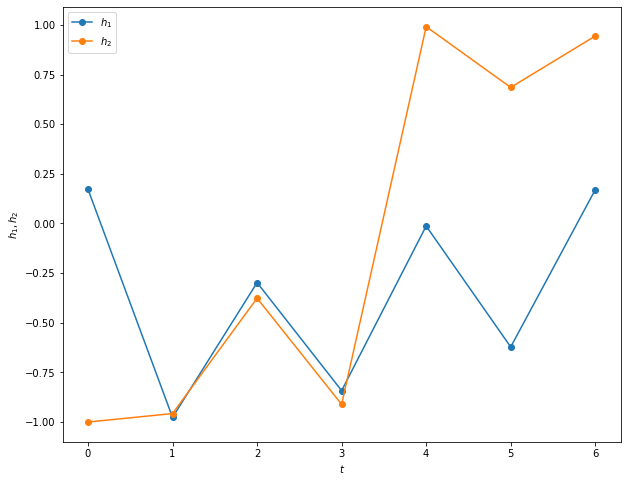

In [9]:
ab =np.transpose(hiddens)

plt.figure(figsize = (10, 8))

for i in range(len(ab)):
    plt.plot(ab[i], 'o-', label = '$h_' + str(i + 1) +'$' )
plt.xlabel(r'$t$')
plt.ylabel(r'$h_1,h_2$')
plt.legend()

因為有2n+1個結果，所以下圖我們可以拆一半去檢視圖，目的只是為了方便閱讀。

另外由於權重輸出為 # 3(output_size)*2(hidden_size)
利用權重畫出拆分為 0/1、1/2以及0/2的線
舉例:
記隱含單元1號和2號到0號輸出單元的加權分別為w10、w20
那麼要讓0號輸出單元啟動的條件就是:
h1w10+h2w20 > 0.5
即
x*w10 + y*w20 = bias
y = -(x*w10 + bias)/w20

(-2, 2)

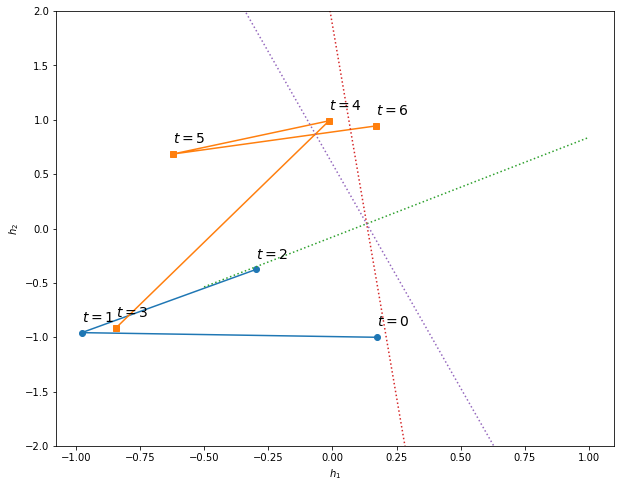

In [10]:
# 將隱含層單元的情況重新繪制到狀態空間中，其中h1為橫坐標，h2為縱坐標。
# 同時，我們將最後一層神經元所對應的分類線也給畫出來
X_reduced = np.array(hiddens)
plt.figure(figsize = (10 , 8))
plt.plot(X_reduced[: n, 0], X_reduced[: n, 1], 'o-')
plt.plot(X_reduced[n :, 0], X_reduced[n :, 1], 's-')
xx = np.linspace(-0.5, 1, 100)

# 將神經網絡的全鏈接層權重和bias信息提取出來
dic = dict(rnn.named_parameters()) #提取出來這個集合
weights = dic['fc.weight'].data.numpy()
bias = dic['fc.bias'].data.numpy()

# 繪制分類線
yy = - ((weights[0][0] - weights[1][0]) * xx  + (bias[0] - bias[1])) / (weights[0][1] - weights[1][1])
plt.plot(xx, yy, ':', label = '0/1', color = 'r')
yy = - ((weights[1][0] - weights[2][0]) * xx  + (bias[1] - bias[2])) / (weights[1][1] - weights[2][1])
plt.plot(xx, yy, ':', label = '1/2', color = 'g')
yy = - ((weights[0][0] - weights[2][0]) * xx  + (bias[0] - bias[2])) / (weights[0][1] - weights[2][1])
plt.plot(xx, yy, ':', label = '0/2', color = 'b')

zhfont1 = matplotlib.font_manager.FontProperties(size=14)
for i in range(len(hiddens)):
    plt.text(X_reduced[i, 0], X_reduced[i, 1] + 0.1, '$t=' + str(i) + '$', fontproperties = zhfont1, alpha = 1)
plt.xlabel(r'$h_1$')
plt.ylabel(r'$h_2$')
plt.ylim([-2, 2])


利用訓練好的神經模型自由生成字符串

In [11]:
input = 3
outstring = '' + str(input)
targets = ''
diff = 0
hiddens = []
hidden = rnn.initHidden()
t = 0 #記錄執行次數，最多執行1000步。
while t < 1000:
    x = torch.tensor([input], dtype = torch.long).unsqueeze(0)
    
    output, hidden = rnn(x, hidden)
    mm = torch.multinomial(output.view(-1).exp(), num_samples = 1 )
    # 由一個list的機率選取其對應的位置(由0算起)，所以會輸出0-2之間的數字一個
    # view 降維
    # 取exp()是因為logsoftmax的結果有負值，而multinomial只能取一正值
    outstring += str(mm.data.numpy()[0])

    input = int(mm.data.numpy()[0])
    t += 1
    if input == 2:
        break
print(t)
print(outstring)


13
30000001111112


## 二、用LSTM來完成字符預測

接下來，我們用一個單一隱含層單元的LSTM來完成完全相同的任務

In [12]:
# 一個手動實現的LSTM模型，除了初始化隱含單元部分，所有代碼基本與SimpleRNN相同

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        super(SimpleLSTM, self).__init__()
        
# 變數
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
# 基本層 
        # 一個embedding層
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 隱含層內部的相互鏈接
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        
        # 先進行embedding層的計算，它可以把一個
        # x的尺寸：batch_size, len_seq, input_size
        x = self.embedding(input)
        # x的尺寸：batch_size, len_seq, hidden_size
        # 從輸入到隱含層的計算
        output, hidden = self.lstm(x, hidden)
        # output的尺寸：batch_size, len_seq, hidden_size
        # hidden: (layer_size, batch_size, hidden_size)
        output = output[:,-1,:]
        # output的尺寸：batch_size, hidden_size
        output = self.fc(output)
        # output的尺寸：batch_size, output_size
        # softmax函數
        output = self.softmax(output)
        return output, hidden
 
    def initHidden(self):
        # 對隱含單元的初始化
        # 注意hidden和cell的維度都是layers,batch_size,hidden_size
        
        # 對隱含單元輸出的初始化，全0.
        hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        # 對隱含單元內部的狀態cell的初始化，全0
        cell = torch.zeros(self.num_layers, 1, self.hidden_size)
        return (hidden, cell)


### 2、訓練神經網絡

In [13]:
lstm = SimpleLSTM(input_size = 4, hidden_size = 1, output_size = 3, num_layers = 1)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)

num_epoch = 50
results = []

# 開始訓練循環
for epoch in range(num_epoch):
    lstm.train()
    train_loss = 0
    np.random.shuffle(train_set)
    # 開始所有訓練數據的循環
    for i, seq in enumerate(train_set):
        loss = 0
        hidden = lstm.initHidden()
        # 開始每一個字符的循環
        for t in range(len(seq) - 1):
            x = torch.tensor([seq[t]], dtype = torch.long).unsqueeze(0)
            # x的尺寸：batch_size, len_seq, hidden_size
            y = torch.tensor([seq[t + 1]], dtype = torch.long)
            # y的尺寸：batch_size, data_dimension
            output, hidden = lstm(x, hidden)
            # output的尺寸：batch_size, data_dimension
            # hidden: (layer_size, batch_size, hidden_size),(layer_size, batch_size,hidden_size)
            loss += criterion(output, y)
        loss = 1.0 * loss / len(seq)
        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        train_loss += loss
        if i > 0 and i % 500 == 0:
            print('第{}輪, 第{}個，訓練Loss:{:.2f}'.format(epoch,
                                                    i,
                                                    train_loss.data.numpy() / i
                                                   ))
            
            
    # 在校驗集上跑結果
    lstm.eval()
    valid_loss = 0
    errors = 0
    show_out = ''
    with torch.no_grad():
        
        for i, seq in enumerate(valid_set):
            loss = 0
            outstring = ''
            targets = ''
            diff = 0
            hidden = lstm.initHidden()
            for t in range(len(seq) - 1):
                x = torch.tensor([seq[t]], dtype = torch.long).unsqueeze(0)
                # x的尺寸：batch_size, len_seq, hidden_size
                y = torch.tensor([seq[t + 1]], dtype = torch.long)
                # y的尺寸：batch_size, data_dimension
                output, hidden = lstm(x, hidden)
                # output的尺寸：batch_size, data_dimension
                # hidden: (layer_size, batch_size, hidden_size),(layer_size, batch_size,hidden_size)
                mm = torch.max(output, 1)[1][0]
                outstring += str(mm.data.numpy())
                targets += str(y.data.numpy()[0])
                loss += criterion(output, y)

                diff += 1 - mm.eq(y).data.numpy()[0]
            loss = 1.0 * loss / len(seq)
            valid_loss += loss
            errors += diff
            if np.random.rand() < 0.1:
                show_out = outstring + '\n' + targets
    print(output[0][2].data.numpy())
    print('第{}輪, 訓練Loss:{:.2f}, 校驗Loss:{:.2f}, 錯誤率:{:.2f}'.format(epoch, 
                                                               train_loss.data.numpy() / len(train_set),
                                                               valid_loss.data.numpy() / len(valid_set),
                                                               1.0 * errors / len(valid_set)
                                                              ))
    print(show_out)
    results.append([train_loss.data.numpy() / len(train_set), 
                    valid_loss.data.numpy() / len(train_set),
                   1.0 * errors / len(valid_set)
                   ])

第0輪, 第500個，訓練Loss:0.91
第0輪, 第1000個，訓練Loss:0.85
第0輪, 第1500個，訓練Loss:0.80
-1.2224634
第0輪, 訓練Loss:0.76, 校驗Loss:0.64, 錯誤率:2.00
000001111
000011112
第1輪, 第500個，訓練Loss:0.63
第1輪, 第1000個，訓練Loss:0.61
第1輪, 第1500個，訓練Loss:0.61
-0.9960015
第1輪, 訓練Loss:0.60, 校驗Loss:0.57, 錯誤率:2.00
00011
00112
第2輪, 第500個，訓練Loss:0.57
第2輪, 第1000個，訓練Loss:0.56
第2輪, 第1500個，訓練Loss:0.56
-0.87783563
第2輪, 訓練Loss:0.55, 校驗Loss:0.54, 錯誤率:2.00
001
012
第3輪, 第500個，訓練Loss:0.54
第3輪, 第1000個，訓練Loss:0.53
第3輪, 第1500個，訓練Loss:0.53
-0.8816471
第3輪, 訓練Loss:0.53, 校驗Loss:0.52, 錯誤率:2.00
00011
00112
第4輪, 第500個，訓練Loss:0.52
第4輪, 第1000個，訓練Loss:0.52
第4輪, 第1500個，訓練Loss:0.51
-0.83580744
第4輪, 訓練Loss:0.51, 校驗Loss:0.51, 錯誤率:2.00
0000111
0001112
第5輪, 第500個，訓練Loss:0.51
第5輪, 第1000個，訓練Loss:0.50
第5輪, 第1500個，訓練Loss:0.50
-0.821917
第5輪, 訓練Loss:0.50, 校驗Loss:0.50, 錯誤率:2.00
00011
00112
第6輪, 第500個，訓練Loss:0.50
第6輪, 第1000個，訓練Loss:0.50
第6輪, 第1500個，訓練Loss:0.50
-0.7781156
第6輪, 訓練Loss:0.49, 校驗Loss:0.49, 錯誤率:2.00
00011
00112
第7輪, 第500個，訓練Loss:0.49
第7輪, 第1000個，訓練Loss:0.49
第7輪, 第

In [14]:
# 保存、提取模型（為展示用）
torch.save(lstm,'lstm.mdl')
lstm = torch.load('lstm.mdl')

In [15]:
# 讓n取0到50，看SimpleLSTM是否能夠成功預測下一個字符
for n in range(50):
    
    inputs = [0] * n + [1] * n
    inputs.insert(0, 3)
    inputs.append(2)
    outstring = ''
    targets = ''
    diff = 0
    hiddens = []
    hidden = lstm.initHidden()
    for t in range(len(inputs) - 1):
        x = torch.tensor([inputs[t]], dtype = torch.long).unsqueeze(0)
        y = torch.tensor([inputs[t + 1]], dtype = torch.long)
        output, hidden = lstm(x, hidden)
        
        mm = torch.max(output, 1)[1][0]
        outstring += str(mm.data.numpy())
        targets += str(y.data.numpy()[0])

        diff += 1 - mm.eq(y).data.numpy()[0]
    print(n)
    print(outstring)
    print(targets)
    print('Diff:{}'.format(diff))

0
0
2
Diff:1
1
011
012
Diff:1
2
01011
00112
Diff:3
3
0100111
0001112
Diff:3
4
010001111
000011112
Diff:3
5
01000011111
00000111112
Diff:3
6
0100000111112
0000001111112
Diff:2
7
010000001111112
000000011111112
Diff:2
8
01000000011111122
00000000111111112
Diff:3
9
0100000000111111222
0000000001111111112
Diff:4
10
010000000001111112222
000000000011111111112
Diff:5
11
01000000000011111112222
00000000000111111111112
Diff:5
12
0100000000000111111122222
0000000000001111111111112
Diff:6
13
010000000000001111111222222
000000000000011111111111112
Diff:7
14
01000000000000011111112222222
00000000000000111111111111112
Diff:8
15
0100000000000000111111122222222
0000000000000001111111111111112
Diff:9
16
010000000000000001111111122222222
000000000000000011111111111111112
Diff:9
17
01000000000000000011111111222222222
00000000000000000111111111111111112
Diff:10
18
0100000000000000000111111112222222222
0000000000000000001111111111111111112
Diff:11
19
010000000000000000001111111122222222222
000000000000000

In [16]:
def calculate(lstm, input, hidden):
        
    # 該函數的作用是計算出在給定的輸入input下，所有門的打開關閉情況、最後的分類結果
    x = lstm.embedding(input)
    output, hidden = lstm.lstm(x, hidden)
    output = output[:,-1,:]

    output = lstm.fc(output)
    # softmax函數
    output = lstm.softmax(output)
    dic = dict(lstm.lstm.named_parameters())
    
    #提取各個中間層的權重
    weight_ih = dic['weight_ih_l0']
    weight_hh = dic['weight_hh_l0']
    bias_ih = dic['bias_ih_l0']
    bias_hh = dic['bias_hh_l0']
    #gt為一個中間變量
    all_gates = weight_ih.mm(x[0])
    gt = torch.tanh(all_gates[2])
    all_gates = torch.sigmoid(all_gates)
    all_gates[2] = gt

    return all_gates, output

### 3. 解剖LSTM

In [17]:
# 固定n＝20，計算每一步LSTM的內部狀態值，並記錄下來
n = 20
inputs = [0] * n + [1] * n
inputs.insert(0, 3)
inputs.append(2)
outstring = ''
targets = ''
diff = 0
hiddens = []
gates = []
outputs = []
hidden = lstm.initHidden()
dicts = dict(lstm.named_parameters())
for t in range(len(inputs) - 1):
    x = torch.tensor([inputs[t]], dtype = torch.long).unsqueeze(0)
    y = torch.tensor([inputs[t + 1]], dtype = torch.long)
    
    gate, out = calculate(lstm, x, hidden)
    outputs.append(np.exp(out.data.numpy()[0]))
    output, hidden = lstm(x, hidden)
    gates.append(gate.data.numpy().reshape(-1))
    hiddens.append(hidden)
    mm = torch.max(output, 1)[1][0]
    outstring += str(mm.data.numpy())
    targets += str(y.data.numpy()[0])

    diff += 1 - mm.eq(y).data.numpy()[0]
print(n)
print(outstring)
print(targets)
print('Diff:{}'.format(diff))


20
01000000000000000000011111111222222222222
00000000000000000000111111111111111111112
Diff:13


#### 繪制曲線

In [18]:
outputs = np.array(outputs)
outputs

array([[9.96592343e-01, 3.40766530e-03, 2.86213029e-13],
       [4.87564892e-01, 5.12387276e-01, 4.77764625e-05],
       [5.51709771e-01, 4.48267877e-01, 2.23669795e-05],
       [6.01957262e-01, 3.98030639e-01, 1.20376799e-05],
       [6.28438950e-01, 3.71552497e-01, 8.56160113e-06],
       [6.42993510e-01, 3.56999487e-01, 7.06102082e-06],
       [6.51428699e-01, 3.48565042e-01, 6.30223303e-06],
       [6.56549633e-01, 3.43444496e-01, 5.87736986e-06],
       [6.59786105e-01, 3.40208292e-01, 5.62198784e-06],
       [6.61905050e-01, 3.38089526e-01, 5.46007686e-06],
       [6.63336217e-01, 3.36658418e-01, 5.35303479e-06],
       [6.64330363e-01, 3.35664302e-01, 5.27975726e-06],
       [6.65038526e-01, 3.34956288e-01, 5.22810433e-06],
       [6.65554404e-01, 3.34440440e-01, 5.19073956e-06],
       [6.65937960e-01, 3.34056914e-01, 5.16312139e-06],
       [6.66228354e-01, 3.33766550e-01, 5.14228577e-06],
       [6.66451931e-01, 3.33542883e-01, 5.12629413e-06],
       [6.66627049e-01, 3.33367

Text(0, 0.5, '$o_i$')

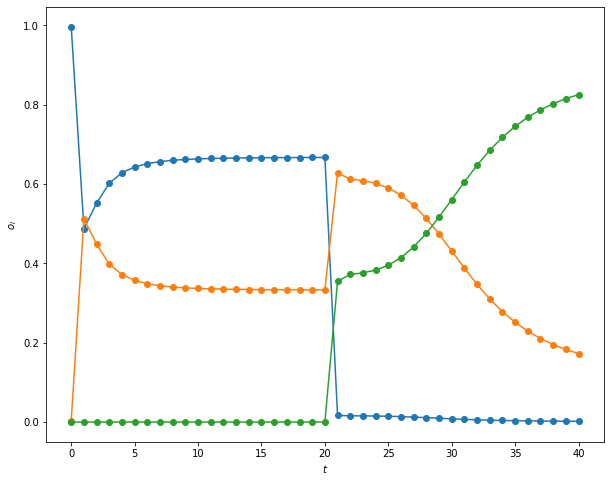

In [20]:
# 繪制輸出層隨時間變化的曲線
outputs = np.array(outputs)
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 22})
#rc('text', usetex=True)
plt.figure(figsize = (10, 8))

plt.plot(outputs, 'o-')
plt.xlabel(r'$t$')
plt.ylabel(r'$o_i$')

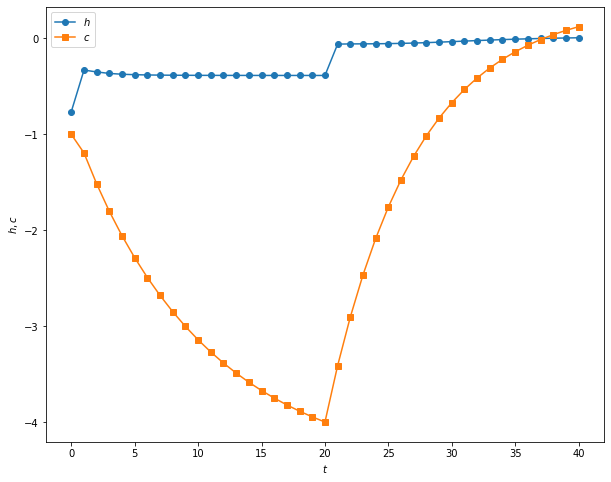

In [21]:
# 繪制隱含層cell與輸出的數值隨時間變化的曲線
states = []
cells = []

for h in hiddens:
    states.append(h[0].data.numpy()[0][0][0])
    cells.append(h[1].data.numpy()[0][0][0])
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 22})
# rc('text', usetex=True)
plt.figure(figsize = (10, 8))

plt.plot(states, 'o-', label = '$h$')
plt.plot(cells, 's-', label = '$c$')
plt.xlabel(r'$t$')
plt.ylabel(r'$h,c$')
plt.legend()

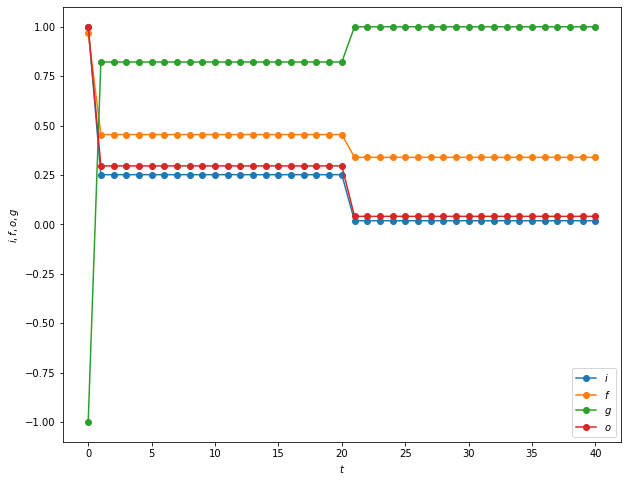

In [22]:
# 繪制各個門控單元的取值狀態
gates = np.array(gates)

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 22})
# rc('text', usetex=True)
plt.figure(figsize = (10, 8))
txts = ['i','f','g','o']
for i in range(len(gates[0])):
    if i != 5:
        plt.plot(gates[:, i], 'o-', label = '$' + txts[i] + '$')
plt.xlabel(r'$t$')
plt.ylabel(r'$i,f,o,g$')
plt.legend()